# Understanding Clouds

#### This methodology is based of the maskrcnn repo: https://github.com/jianing-sun/Mask-YOLO.

In [1]:
! pip install tensorflow-gpu==2.0.0
! pip install efficientnet==1.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 46.8MB/s 
     |████████████████████████████████| 3.8MB 36.1MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [0]:
# Importing packages
import os, glob

import random
import numpy as np
import pandas as pd

import cv2
from albumentations import Compose, VerticalFlip, HorizontalFlip, RandomRotate90, GridDistortion, CenterCrop, OpticalDistortion, ElasticTransform

import multiprocessing
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import  LeakyReLU, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [16]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=e15fa416233b9f818fef0050697b287622686e81683c55bce8142ce3f9d96ed9
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 421.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
# Setting run specfic values

num_cores = 2496

debug = True

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

%matplotlib inline

test_imgs_folder = "/content/data/test_images/"
train_imgs_folder = "/content/data/train_images/"

In [0]:
# Helper functions from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools

def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    From https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')
  

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    From https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.
    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)


In [0]:
# Sourced from: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Upload the kaggle.json file that is downloaded when creating a kaggle api

# Import Data

In [21]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [22]:
# Download the dataset from kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c understanding_cloud_organization

 99% 3.43G/3.44G [00:33<00:00, 118MB/s]
100% 3.44G/3.44G [00:34<00:00, 109MB/s]
100% 2.29G/2.30G [00:29<00:00, 43.9MB/s]
100% 2.30G/2.30G [00:29<00:00, 83.3MB/s]
 79% 43.0M/54.2M [00:00<00:00, 49.6MB/s]
100% 54.2M/54.2M [00:00<00:00, 91.8MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 96.8MB/s]


In [0]:
# Unzip the data
! mkdir data
! mkdir data/train_images
! mkdir data/test_images
! unzip train_images.zip -d data/train_images;
! unzip test_images.zip -d data/test_images;
! unzip train.csv.zip -d data
! mv sample_submission.csv /content/data

In [25]:
if debug:
    train_df = pd.read_csv("/content/data/train.csv", nrows=512)
else:
    train_df = pd.read_csv("/content/data/train.csv")
    
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 2 columns):
Image_Label      512 non-null object
EncodedPixels    290 non-null object
dtypes: object(2)
memory usage: 8.1+ KB
None


Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

# Explore the data

In [26]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class', 'EncodedPixels'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
    train_df['index'] = train_df['Class'].map(lambda x: list(x).index(class_name) if class_name in x else 0)
    train_df[f"{class_name}_Enc_Pix"] = train_df.apply(lambda x: list(x['EncodedPixels'])[x['index']] if class_name in x['Class'] else float('nan'), axis=1)
train_df.drop(columns=['EncodedPixels', 'index'], inplace=True)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
Image             128 non-null object
Class             128 non-null object
Fish              128 non-null int64
Fish_Enc_Pix      69 non-null object
Flower            128 non-null int64
Flower_Enc_Pix    59 non-null object
Sugar             128 non-null int64
Sugar_Enc_Pix     93 non-null object
Gravel            128 non-null int64
Gravel_Enc_Pix    69 non-null object
dtypes: int64(4), object(6)
memory usage: 10.1+ KB
None


Image  ...                                     Gravel_Enc_Pix
0  0011165.jpg  ...                                                NaN
1  002be4f.jpg  ...                                                NaN
2  0031ae9.jpg  ...                                                NaN
3  0035239.jpg  ...  65400 380 66800 380 68200 380 69600 380 71000 ...
4  003994e.jpg  ...  353317 416 354717 416 356117 416 357517 416 35...

[5 rows x 10 columns]

Text(0.5, 1.0, 'Count by Class')

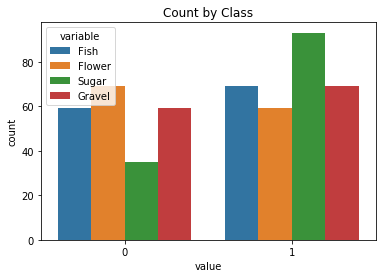

In [27]:
sns.countplot(x="value", hue="variable", data=pd.melt(train_df[['Fish', 'Flower', 'Sugar', 'Gravel']])).set_title("Count by Class")

In [0]:
def plot_image(image=np.random.choice(train_df['Image']), figsize=(15, 10), im_size=(1400,2100), augment=None):
    # Rerun this cell to see diferent images
    fig = plt.figure(figsize=figsize)
    im = cv2.cvtColor(cv2.imread(f"{train_imgs_folder}/{image}"), cv2.COLOR_BGR2RGB)
    for i, class_name in enumerate(classes):
        ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
        mask_rle = (train_df[f'{class_name}_Enc_Pix']
                    .where(train_df['Image'] == image)
                    .dropna())
        try:
            mask = np.array(rle_decode(mask_rle.iloc[0], (1400, 2100)))[..., np.newaxis]
        except:
            mask = np.zeros((1400, 2100, 1))
        if augment:
            augmented = augment(image=im, mask=mask)
            im_out = cv2.resize(augmented['image'], im_size)
            mask_out = cv2.resize(augmented['mask'], im_size)
            bbox_out = extract_bboxes(mask_out[..., np.newaxis])
        else:
            im_out = cv2.resize(im, im_size)
            print("Im", im_out.shape)
            mask_out = cv2.resize(mask, im_size)
            print("mask", mask_out.shape)
            bbox_out = extract_bboxes(mask_out[..., np.newaxis])
            print("bb", bbox_out.shape)

        # Create a box patch
        patch = patches.Rectangle((bbox_out[:,1], bbox_out[:,0]), 
                                  bbox_out[:,3]-bbox_out[:,1], 
                                  bbox_out[:,2]-bbox_out[:,0], 
                                  linewidth=3, edgecolor='r', facecolor='none')
        plt.imshow(im_out)
        ax.add_patch(patch)
        plt.imshow(-mask_out, alpha=0.2, cmap='binary')
        ax.set_title(f"Image: {image}, Class: {class_name}")

Im (350, 525, 3)
mask (350, 525)
bb (1, 4)
Im (350, 525, 3)
mask (350, 525)
bb (1, 4)
Im (350, 525, 3)
mask (350, 525)
bb (1, 4)
Im (350, 525, 3)
mask (350, 525)
bb (1, 4)


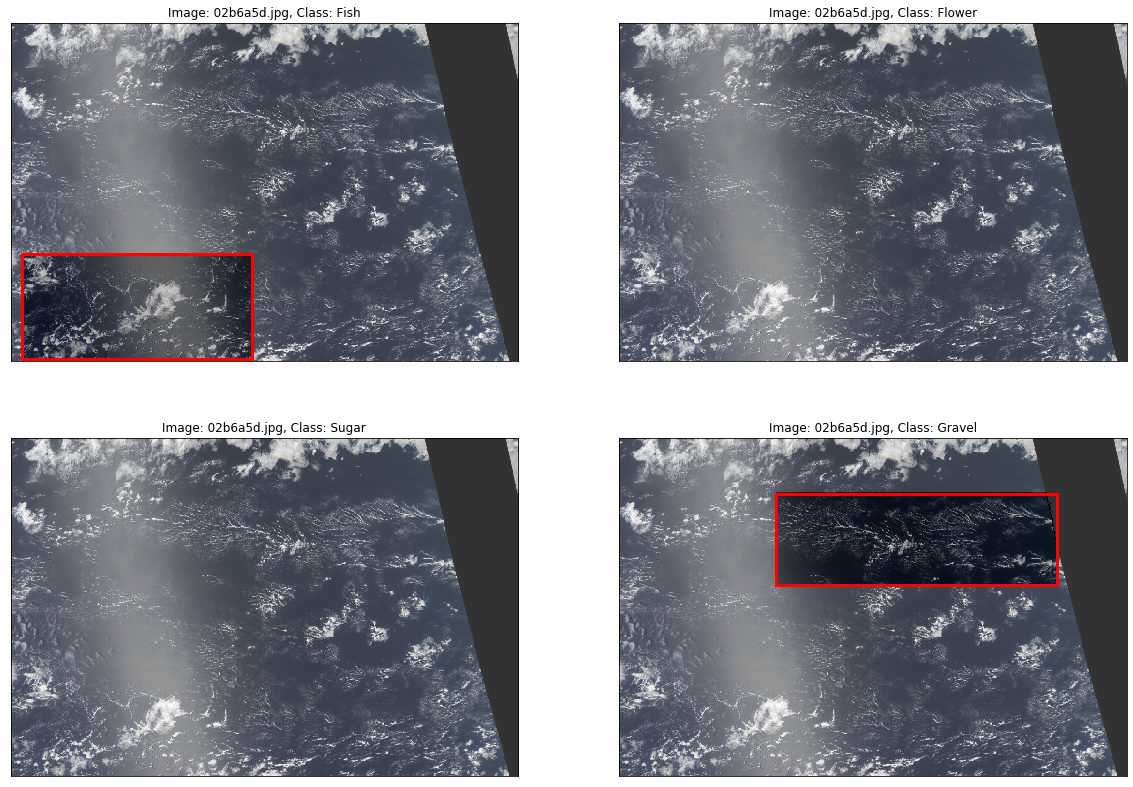

In [29]:
#Plot the original image with masks
im = np.random.choice(train_df['Image'])
figsize=(20, 14)
im_size=(525,350)
plot_image(image=im, figsize=figsize, im_size=im_size)

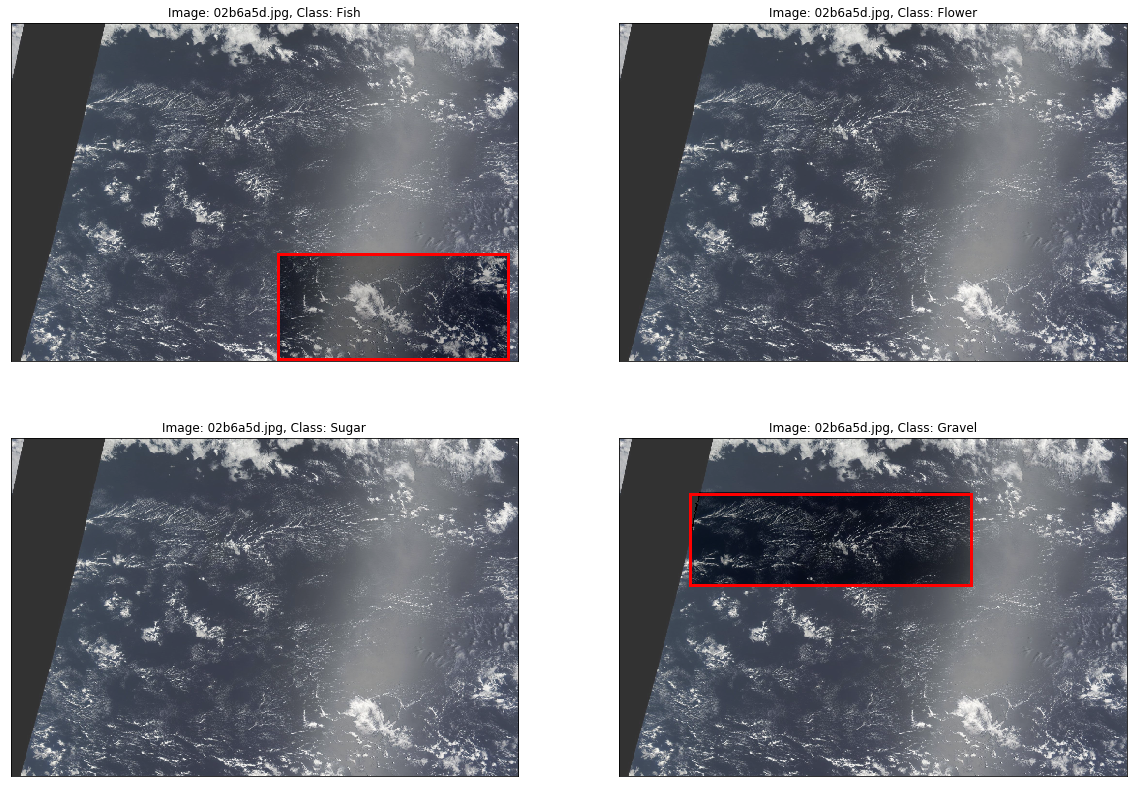

In [30]:
#Plot the original image with masks
plot_image(image=im, figsize=figsize, im_size=im_size, augment=HorizontalFlip(p=1.0))

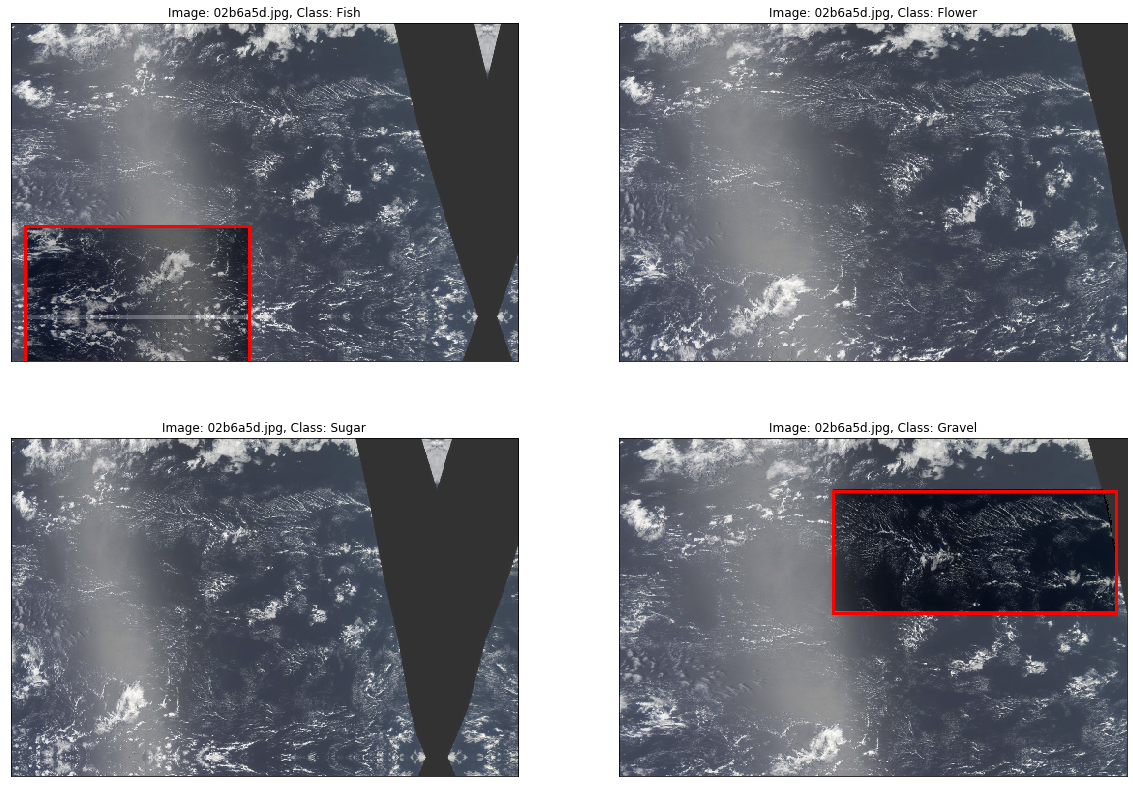

In [31]:
#Plot the grid distorted image with masks
plot_image(image=im, figsize=figsize, im_size=im_size, augment=GridDistortion(p=1))

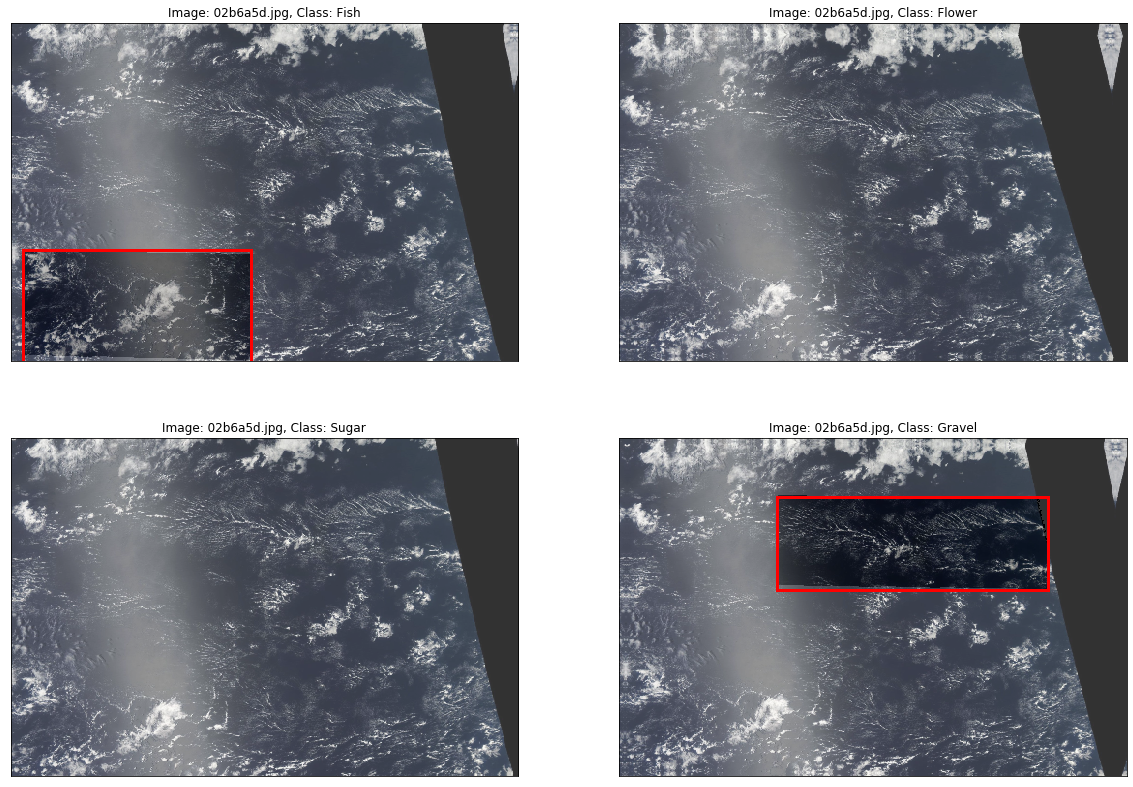

In [32]:
# Plot the elatic transfomed image with masks
plot_image(image=im, figsize=figsize, im_size=im_size, augment=ElasticTransform(p=1, alpha=120, sigma=120 * 0.2, alpha_affine=120 * 0.2))

# Data Generators

In [0]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df[['Fish', 'Flower', 'Sugar', 'Gravel']].values)}

In [0]:
# sorting present classes in lexicographical order, just to be sure
stratify = train_df['Class'].map(lambda x: str(sorted(list(x))))

train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=stratify,
                                        random_state=random_seed)

In [0]:
class CloudGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, batch_size=32, shuffle=True, 
                 augmentation=None, resized_height=380, resized_width=380, num_channels=3, 
                 num_classes=4, Classes=[], output_type='mask'):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.im_size = (resized_width, resized_height)
        self.num_channels = num_channels
        # self.Classes = Classes
        self.num_classes = num_classes
        self.output_type = output_type
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __cloud_generation(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y_masks = np.empty((self.batch_size, self.num_classes, self.resized_height, self.resized_width))
        y_bboxs = np.empty((self.batch_size, self.num_classes, 1, 4))
        y_labels = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            masks = np.empty((self.num_classes, self.resized_height, self.resized_width))
            bboxs = np.empty((self.num_classes, 1, 4))

            for j in range(self.num_classes):
                try:
                    mask = np.array(rle_decode(mask_rle.iloc[0], (1400, 2100)))[..., np.newaxis]
                except:
                    mask = np.zeros((1400, 2100, 1))
                if self.augmentation:
                    augmented = self.augmentation(image=img, mask=mask)
                    mask = cv2.resize(augmented['mask'], self.im_size)
                    bbox = extract_bboxes(mask[..., np.newaxis])
                else:
                    mask = cv2.resize(mask, self.im_size)
                    bbox = extract_bboxes(mask[..., np.newaxis])
                masks[j, :, :] = mask
                bboxs[j, :, :] = bbox

            if self.augmentation:
                augmented = self.augmentation(image=img)
                img = augmented['image']

            img = cv2.resize(img, (self.resized_width, self.resized_height))
            X[i, :, :, :] = img/255.0
            y_masks[i, :, : , :] = masks
            y_bboxs[i, :, : , :] = bboxs
            y_labels[i, :] = img_2_ohe_vector[image_name]
        return X, y_masks, y_bboxs, y_labels

    def __getitem__(self, idx):
        X, y_masks, y_bboxs, y_labels = self.__cloud_generation(idx)
        if self.output_type == 'mask':
            return X, y_masks
        if self.output_type == 'bbox':
            return X, y_bboxs
        if self.output_type == 'class':
            return X, y_labels

In [0]:
albumentations_train = Compose([VerticalFlip(), HorizontalFlip(), RandomRotate90(), GridDistortion(), ElasticTransform(alpha=120, sigma=120 * 0.2, alpha_affine=120 * 0.2)], p=1)

In [0]:
if debug == True:
  batch_size = 8
else:
  batch_size = 128

# Mask


In [0]:
# Model Architecture from xhlulus amazing Kernel: https://www.kaggle.com/xhlulu/severstal-u-net-with-efficientnetb4

def H(lst, name, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1, name=name+'_gn')
    else:
        norm = BatchNormalization(name=name+'_bn')
    
    x = concatenate(lst)
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2D(num_filters, (2, 2), padding='same', name=name)(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1, name=name+'_activation')(x)
    
    return x


def U(x, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1)
    else:
        norm = BatchNormalization()
    
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

In [49]:
def EfficientUNet(input_shape):
    backbone = efn.EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # backbone.load_weights("/content/data/efficientnetb4.h5")

    input = backbone.input
    x00 = backbone.input  # (256, 512, 3)
    x10 = backbone.get_layer('stem_activation').output  # (128, 256, 4)
    x20 = backbone.get_layer('block2d_add').output  # (64, 128, 32)
    x30 = backbone.get_layer('block3d_add').output  # (32, 64, 56)
    x40 = backbone.get_layer('block5f_add').output  # (16, 32, 160)
    x50 = backbone.get_layer('block7b_add').output  # (8, 16, 448)
    
    x01 = H([x00, U(x10)], 'X01')
    x11 = H([x10, U(x20)], 'X11')
    x21 = H([x20, U(x30)], 'X21')
    x31 = H([x30, U(x40)], 'X31')
    x41 = H([x40, U(x50)], 'X41')
    
    x02 = H([x00, x01, U(x11)], 'X02')
    x12 = H([x11, U(x21)], 'X12')
    x22 = H([x21, U(x31)], 'X22')
    x32 = H([x31, U(x41)], 'X32')
    
    x03 = H([x00, x01, x02, U(x12)], 'X03')
    x13 = H([x12, U(x22)], 'X13')
    x23 = H([x22, U(x32)], 'X23')
    
    x04 = H([x00, x01, x02, x03, U(x13)], 'X04')
    x14 = H([x13, U(x23)], 'X14')
    
    x05 = H([x00, x01, x02, x03, x04, U(x14)], 'X05')
    
    x_out = Concatenate(name='bridge')([x01, x02, x03, x04, x05])
    x_out = Conv2D(4, (3,3), padding="same", name='final_output', activation="sigmoid")(x_out)
    
    return Model(inputs=input, outputs=x_out)

model = EfficientUNet((256, 512, 3))
model.compile(optimizer=Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 256, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 256, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
# model.load_weights("/content/data/efficientnetb4.h5")

In [51]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.7 GB  | Proc size: 4.2 GB
GPU RAM Free: 407MB | Used: 11034MB | Util  96% | Total 11441MB


In [0]:
data_generator_train = CloudGenenerator(images_list=train_imgs, augmentation=albumentations_train, 
                                        resized_height=256, resized_width=512, batch_size=batch_size, output_type='mask')
data_generator_train_eval = CloudGenenerator(images_list=train_imgs, shuffle=False, resized_height=256, resized_width=512, 
                                             batch_size=batch_size, output_type='mask')
data_generator_val = CloudGenenerator(images_list=val_imgs, shuffle=False, resized_height=256, resized_width=512, 
                                      batch_size=batch_size, output_type='mask')

In [60]:
if debug:
    num_epochs = 1
else:
    num_epochs = 20

for base_layer in model.layers[:-3]:
    base_layer.trainable = False

history_0 = model.fit_generator(generator=data_generator_train,
                                validation_data=data_generator_val,
                                epochs=num_epochs,
                                # callbacks=[],
                                workers=num_cores,
                                verbose=1)

ResourceExhaustedError: ignored

# Bounding Box

In [0]:
# model.load_weights("../input/cloudmodels/EfficientNetB4.h5")

# Classifier

## PR-AUC-based Callback

In [0]:
class PrAucCallback(Callback):
    def __init__(self, data_generator, num_workers=num_cores, 
                 early_stopping_patience=5, 
                 plateau_patience=3, reduction_rate=0.5,
                 stage='train', checkpoints_path='checkpoints/'):
        super(Callback, self).__init__()
        self.data_generator = data_generator
        self.num_workers = num_workers
        self.class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
        self.history = [[] for _ in range(len(self.class_names) + 1)] # to store per each class and also mean PR AUC
        self.early_stopping_patience = early_stopping_patience
        self.plateau_patience = plateau_patience
        self.reduction_rate = reduction_rate
        self.stage = stage
        self.best_pr_auc = -float('inf')
        if not os.path.exists(checkpoints_path):
            os.makedirs(checkpoints_path)
        self.checkpoints_path = checkpoints_path
        
    def compute_pr_auc(self, y_true, y_pred):
        pr_auc_mean = 0
        print(f"\n{'#'*30}\n")
        for class_i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/len(self.class_names)
            print(f"PR AUC {self.class_names[class_i]}, {self.stage}: {pr_auc:.3f}\n")
            self.history[class_i].append(pr_auc)        
        print(f"\n{'#'*20}\n PR AUC mean, {self.stage}: {pr_auc_mean:.3f}\n{'#'*20}\n")
        self.history[-1].append(pr_auc_mean)
        return pr_auc_mean
              
    def is_patience_lost(self, patience):
        if len(self.history[-1]) > patience:
            best_performance = max(self.history[-1][-(patience + 1):-1])
            return best_performance == self.history[-1][-(patience + 1)] and best_performance >= self.history[-1][-1]    
              
    def early_stopping_check(self, pr_auc_mean):
        if self.is_patience_lost(self.early_stopping_patience):
            self.model.stop_training = True    
              
    def model_checkpoint(self, pr_auc_mean, epoch):
        if pr_auc_mean > self.best_pr_auc:
            # remove previous checkpoints to save space
            for checkpoint in glob.glob(os.path.join(self.checkpoints_path, 'classifier_densenet169_epoch_*')):
                os.remove(checkpoint)
            self.best_pr_auc = pr_auc_mean
            self.model.save(os.path.join(self.checkpoints_path, f'classifier_densenet169_epoch_{epoch}_val_pr_auc_{pr_auc_mean}.h5'))              
            print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
              
    def reduce_lr_on_plateau(self):
        if self.is_patience_lost(self.plateau_patience):
            new_lr = float(keras.backend.get_value(self.model.optimizer.lr)) * self.reduction_rate
            keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\n{'#'*20}\nReduced learning rate to {new_lr}.\n{'#'*20}\n")
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_generator(self.data_generator, workers=self.num_workers)
        y_true = self.data_generator.get_labels()
        # estimate AUC under precision recall curve for each class
        pr_auc_mean = self.compute_pr_auc(y_true, y_pred)
              
        if self.stage == 'val':
            # early stop after early_stopping_patience=4 epochs of no improvement in mean PR AUC
            self.early_stopping_check(pr_auc_mean)

            # save a model with the best PR AUC in validation
            self.model_checkpoint(pr_auc_mean, epoch)

            # reduce learning rate on PR AUC plateau
            self.reduce_lr_on_plateau()            
        
    def get_pr_auc_history(self):
        return self.history

In [0]:
train_metric_callback = PrAucCallback(data_generator_train_eval)
val_callback = PrAucCallback(data_generator_val, stage='val')

In [0]:
def get_model():
    base_model = efn.EfficientNetB2(weights='imagenet', include_top=False, pooling='max', input_shape=(350, 525, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

In [0]:
if debug:
    num_epochs = 5
else:
    num_epochs = 20

for base_layer in model.layers[:-3]:
    base_layer.trainable = False
    
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy')
history_0 = model.fit_generator(generator=data_generator_train,
                                validation_data=data_generator_val,
                                epochs=num_epochs,
                                callbacks=[train_metric_callback, val_callback],
                                workers=num_cores,
                                verbose=1)

Epoch 1/5
5/6 [========================>.....] - ETA: 15s - loss: 3.2265
##############################

PR AUC Fish, train: 0.625

PR AUC Flower, train: 0.557

PR AUC Sugar, train: 0.665

PR AUC Gravel, train: 0.671


####################
 PR AUC mean, train: 0.629
####################


##############################

PR AUC Fish, val: 0.420

PR AUC Flower, val: 0.541

PR AUC Sugar, val: 0.947

PR AUC Gravel, val: 0.522


####################
 PR AUC mean, val: 0.608
####################


####################
Saved new checkpoint
####################

6/6 [==============================] - 170s 28s/step - loss: 3.1618 - val_loss: 3.1174
Epoch 2/5
5/6 [========================>.....] - ETA: 1s - loss: 3.1677
##############################

PR AUC Fish, train: 0.682

PR AUC Flower, train: 0.611

PR AUC Sugar, train: 0.669

PR AUC Gravel, train: 0.737


####################
 PR AUC mean, train: 0.675
####################


##############################

PR AUC Fish, val: 0.446

PR AUC

## Fine-tuning the whole model

In [0]:
if debug:
    num_epochs = 5
    initial_epoch = 2
else:
    num_epochs = 20
    initial_epoch = 3
    
for base_layer in model.layers[:-3]:
    base_layer.trainable = True
    
model.compile(optimizer=Adam(lr=5e-6), loss='categorical_crossentropy')
history_1 = model.fit_generator(generator=data_generator_train,
                              validation_data=data_generator_val,
                              epochs=num_epochs,
                              callbacks=[train_metric_callback, val_callback],
                              workers=num_cores,
                              verbose=1,
                              initial_epoch=initial_epoch
                             )

Epoch 3/5
5/6 [========================>.....] - ETA: 1s - loss: 3.3070
##############################

PR AUC Fish, train: 0.671

PR AUC Flower, train: 0.575

PR AUC Sugar, train: 0.874

PR AUC Gravel, train: 0.703


####################
 PR AUC mean, train: 0.706
####################


##############################

PR AUC Fish, val: 0.630

PR AUC Flower, val: 0.466

PR AUC Sugar, val: 0.720

PR AUC Gravel, val: 0.762


####################
 PR AUC mean, val: 0.645
####################

6/6 [==============================] - 27s 4s/step - loss: 3.2820 - val_loss: 3.1069
Epoch 4/5
5/6 [========================>.....] - ETA: 0s - loss: 3.2709
##############################

PR AUC Fish, train: 0.683

PR AUC Flower, train: 0.560

PR AUC Sugar, train: 0.870

PR AUC Gravel, train: 0.703


####################
 PR AUC mean, train: 0.704
####################


##############################

PR AUC Fish, val: 0.504

PR AUC Flower, val: 0.426

PR AUC Sugar, val: 0.710

PR AUC Gravel, val: 0

In [0]:
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)

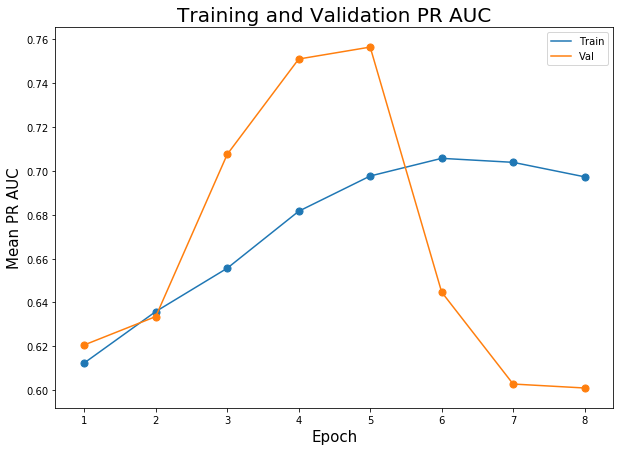

In [0]:
pr_auc_history_train = train_metric_callback.get_pr_auc_history()
pr_auc_history_val = val_callback.get_pr_auc_history()

plt.figure(figsize=(10, 7))
plot_with_dots(plt, pr_auc_history_train[-1])
plot_with_dots(plt, pr_auc_history_val[-1])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean PR AUC', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation PR AUC', fontsize=20)
plt.savefig('pr_auc_hist.png')

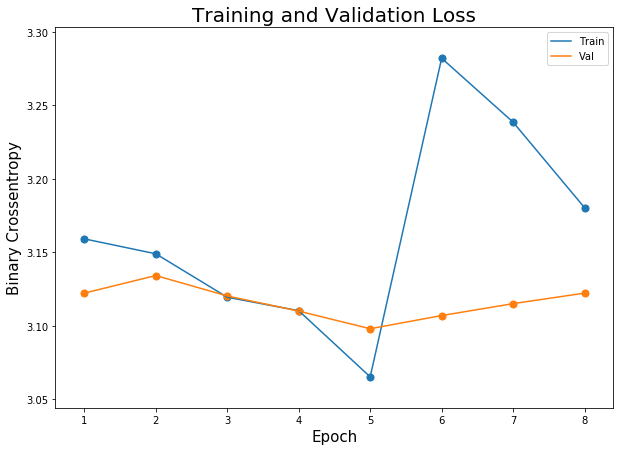

In [0]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history_0.history['loss']+history_1.history['loss'])
plot_with_dots(plt, history_0.history['val_loss']+history_1.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

## Selecting postprocessing thresholds

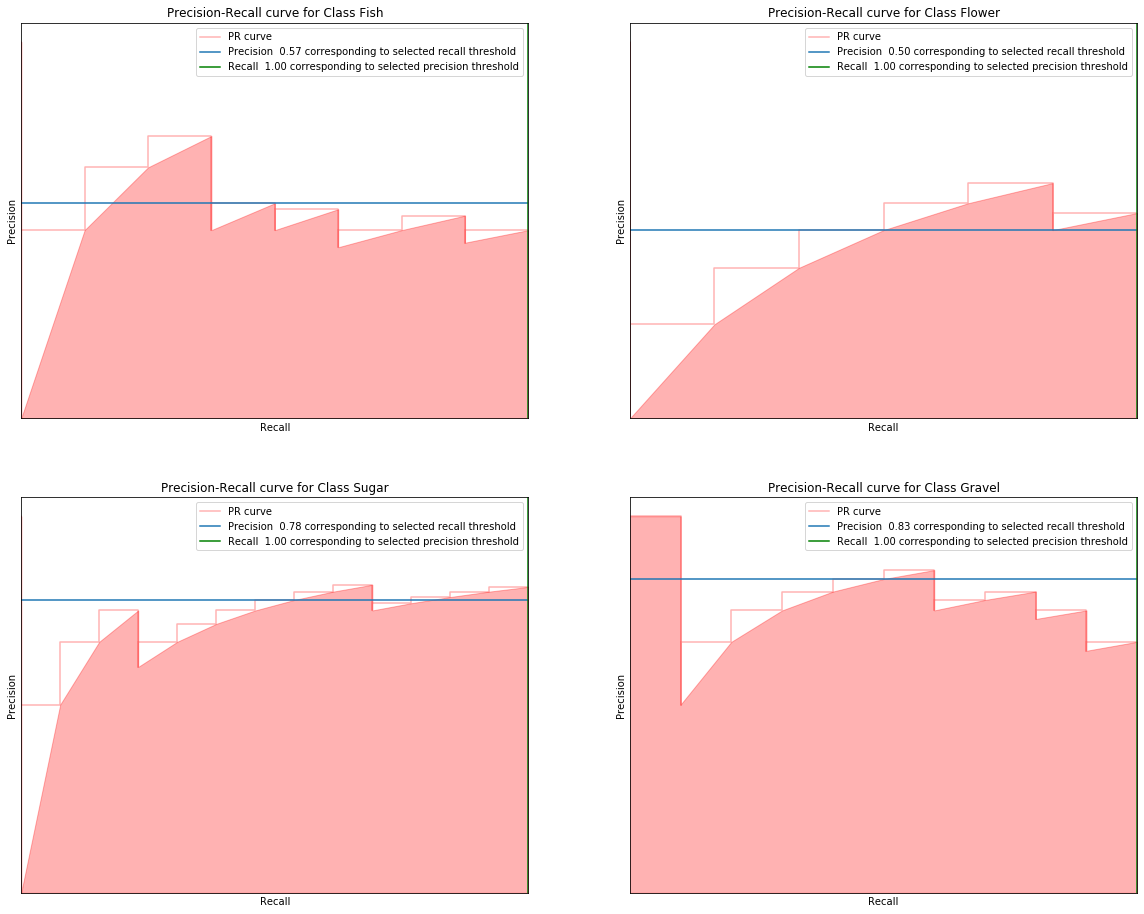

In [0]:
if debug == True:
    recall_threshold=0.5
    precision_threshold=0.50
else:
    recall_threshold=0.94
    precision_threshold=0.90

class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.90, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])  
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold][0]
    
    if plot:
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) 
                                 if thres == best_precision_threshold][0]
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()

precision_thresholds = dict()
fig = plt.figure(figsize=(20, 16))
for i, class_name in enumerate(class_names):
    ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, 
                                                                                               recall_threshold=recall_threshold, 
                                                                                               precision_threshold=precision_threshold, 
                                                                                               plot=True)

## Postprocessing


In [0]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

In [0]:
print(y_pred_test)

[[0.40212703 0.463376   0.6164782  0.569886  ]
 [0.52533245 0.5213703  0.76654077 0.626779  ]
 [0.52865064 0.44566786 0.6691036  0.53780633]
 ...
 [0.4329218  0.37776333 0.7530346  0.59872556]
 [0.53689295 0.5726849  0.6932655  0.68182486]
 [0.41091764 0.40314713 0.5830154  0.5744105 ]]


In [0]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

In [0]:
print(image_labels_empty)

{'e8db1ff.jpg_Gravel', '44e538a.jpg_Gravel', 'd898344.jpg_Flower', 'c17d6a1.jpg_Flower', '3e2bf7e.jpg_Gravel', '85e67ce.jpg_Flower', '90e2586.jpg_Flower', '0d852ed.jpg_Fish', 'e48ff0f.jpg_Sugar', '2f3c5f3.jpg_Flower', '1a3535a.jpg_Flower', '1f160af.jpg_Gravel', '147d914.jpg_Flower', 'd1378d2.jpg_Flower', '0b5d19e.jpg_Fish', 'dc6a8dc.jpg_Fish', '6e5d699.jpg_Flower', '84ee465.jpg_Fish', '36cef57.jpg_Sugar', '8944b57.jpg_Fish', '5175361.jpg_Flower', '3a0f68e.jpg_Gravel', 'c6ef6d0.jpg_Sugar', '7767856.jpg_Gravel', '72686d4.jpg_Sugar', 'd37f996.jpg_Flower', 'b908920.jpg_Gravel', 'c2db00e.jpg_Sugar', '948c7b0.jpg_Fish', '442c91e.jpg_Gravel', '9ae4b32.jpg_Sugar', 'd66db31.jpg_Gravel', 'ab05b5b.jpg_Flower', '1883c10.jpg_Fish', '882008c.jpg_Flower', 'a87e859.jpg_Gravel', 'c89b983.jpg_Fish', 'dd3ca7f.jpg_Gravel', '6ae7aa1.jpg_Sugar', 'e894150.jpg_Fish', '8ed4866.jpg_Sugar', 'cf268e6.jpg_Fish', '9bd4491.jpg_Flower', 'ea91bb4.jpg_Flower', 'ab05b5b.jpg_Sugar', 'a2388c2.jpg_Flower', 'd91482f.jpg_Flo

In [0]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [0]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_segmentation_and_classifier.csv', index=None)